## 0. Enunciado

En este ejercicio se propone un conjunto de datos recopilado a partir de un escenario en el que se han realizado un conjunto de ataques sobre una infraestructura de red.  

El objetivo del ejercicio es construir un modelo capaz de identificar este tipo de ataques en una infraestructura de red real. Para completar el ejercicio satisfactoriamente el alumno debe:
* Construir un modelo predictivo utilizando un **algoritmo de clasficación** basado en apredizaje supervisado (regresión logistica, árbol de decisión, random forests)
* Construir un modelo predictivo utilizando un **algoritmo de detección de anomalías** (distribución gaussiana, isolation forest)
* **Completar las secciones** que se presentan a lo largo de este jupyter notebook

### Dataset

#### Abstract
NSL-KDD is a data set suggested to solve some of the inherent problems of the KDD'99 data set which are mentioned in [1]. Although, this new version of the KDD data set still suffers from some of the problems discussed by McHugh [2] and may not be a perfect representative of existing real networks, because of the lack of public data sets for network-based IDSs, we believe it still can be applied as an effective benchmark data set to help researchers compare different intrusion detection methods. Furthermore, the number of records in the NSL-KDD train and test sets are reasonable. This advantage makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research work will be consistent and comparable.

#### Data Files
* KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format
* **KDDTrain+.TXT**: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* **KDDTest+.TXT**:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

## 1. Lectura del conjunto de datos

Carga el conjunto de datos utilizando alguno de los frameworks que se ha visto durante la realización de los ejercicios del curso:
* Almacena los datos en las variables adecuadas
* Separa el conjunto de datos en las características de entrada y el valor de salida (etiqueta)
* **Separa el conjunto de datos en los subconjuntos de entramiento, validación y pruebas**

**NOTA**: He descargado los datasets el archivo ZIP de la página web https://www.kaggle.com/hassan06/nslkdd con todos los archivos y los he almacenado en una carpeta llamada NSL-KDD, al mismo nivel de este notebook.

In [10]:
from datetime import datetime
import pytz

# Returns the string delimited by two characters.
# Example: parse_str('[my string]') => 'my string'
def parse_str(x):
    return x[1:-1]

# Parses datetime with timezone formatted as: [day/month/year:hour:minute:second zone]
# Example: parse_datetime('13/Nov/2015:11:45:42 +0000') 
#    => datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)

def parse_datetime(x):
    dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

In [15]:
import re
import pandas as pd

data = pd.read_csv(
    'datasets/access.log',
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    # nrows=30,
    na_values='-',
    header=None,
    usecols=[0, 3, 4, 5, 6, 7, 8],
    names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
    converters={'time': parse_datetime,
                'request': parse_str,
                'status': int,
                'size': int,
                'referer': parse_str,
                'user_agent': parse_str})

ValueError: time data '' does not match format '%d/%b/%Y:%H:%M:%S'

In [14]:
data

,ip,time,request,status,size,referer,user_agent
0,109.169.248.247,2015-12-12 18:25:11+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
1,109.169.248.247,2015-12-12 18:25:11+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
2,46.72.177.4,2015-12-12 18:31:08+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
3,46.72.177.4,2015-12-12 18:31:08+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
4,83.167.113.100,2015-12-12 18:31:25+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
5,83.167.113.100,2015-12-12 18:31:25+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
6,95.29.198.15,2015-12-12 18:32:10+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
7,95.29.198.15,2015-12-12 18:32:11+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
8,109.184.11.34,2015-12-12 18:32:56+01:00,GET /administrator/ HTTP/1.1,200,4263,NaN,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...
9,109.184.11.34,2015-12-12 18:32:56+01:00,POST /administrator/index.php HTTP/1.1,200,4494,http://almhuette-raith.at/administrator/,Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20...


In [316]:
# Load Test data
X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [317]:
# Validation data
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X_train, test_size=0.20, random_state=42)

In [318]:
# Comprobacion de número de datos en cada conjunto
print("Número de registros para entrenamiento:", X_train.shape[0])
print("Número de registros de test:", X_test.shape[0])
print("Número de registros para la validación:", X_val.shape[0])

Número de registros para entrenamiento: 100778
Número de registros de test: 22544
Número de registros para la validación: 25195


## 2. Visualización del conjunto de datos para ganar intuiciones

El proceso de visualización siempre debe realizarse sobre el training set y apartando el test set. Esto evita que nuestro cerebro genere intuiciones del test set que podemos incorporar en nuestro modelo.  

Una buena práctica es crear una copia del training set y jugar con ella. De esta manera, si realizamos transformaciones que dañan el tranning set, el original no se ve afectado.  

Visualiza los valores de las características de entrada del conjunto de datos. 
* Visualiza las columnas y filas del conjunto de datos
* Visualiza la información del conjunto de datos
* Cuenta los valores distintos que existen para las columnas categoricas
* Visualiza la distribución de los atributos del conjunto de datos de manera genérica
* ...

In [319]:
# Copia del dataset de entrenamiento a uno nuevo
df2 = X_train.copy()

In [320]:
# Visualización de  las columnas y filas del conjunto de datos
df2.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class
95141,0,tcp,http,SF,214,14939,0,0,0,0,...,255,1.00,0.00,0.02,0.06,0.0,0.0,0.0,0.0,normal
37486,0,tcp,private,S0,0,0,0,0,0,0,...,2,0.01,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune
34926,0,tcp,http,REJ,0,0,0,0,0,0,...,8,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune
34589,0,tcp,http,SF,257,259,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal
11420,0,udp,other,SF,516,4,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,normal
46955,0,tcp,private,S0,0,0,0,0,0,0,...,20,0.08,0.07,0.00,0.00,1.0,1.0,0.0,0.0,neptune
32661,0,tcp,smtp,RSTO,0,0,0,0,0,0,...,1,0.00,1.00,1.00,0.00,0.0,0.0,1.0,1.0,portsweep
21066,0,icmp,eco_i,SF,8,0,0,0,0,0,...,129,1.00,0.00,1.00,0.50,0.0,0.0,0.0,0.0,ipsweep
22128,0,tcp,private,S0,0,0,0,0,0,0,...,17,0.07,0.08,0.00,0.00,1.0,1.0,0.0,0.0,neptune
21455,0,udp,private,SF,1,0,0,0,0,0,...,110,0.43,0.06,1.00,0.00,0.0,0.0,0.0,0.0,satan


In [321]:
# Visualización de la información del conjunto de datos
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100778 entries, 95141 to 121958
Data columns (total 42 columns):
duration                       100778 non-null int64
protocol_type                  100778 non-null object
service                        100778 non-null object
flag                           100778 non-null object
src_bytes                      100778 non-null int64
dst_bytes                      100778 non-null int64
land                           100778 non-null int64
wrong_fragment                 100778 non-null int64
urgent                         100778 non-null int64
hot                            100778 non-null int64
num_failed_logins              100778 non-null int64
logged_in                      100778 non-null int64
num_compromised                100778 non-null int64
root_shell                     100778 non-null int64
su_attempted                   100778 non-null int64
num_root                       100778 non-null int64
num_file_creations             100

In [322]:
# Número de valores distintos que existen para la columnas categorica 'protocol_type'
df2['protocol_type'].value_counts()

tcp     82154
udp     12046
icmp     6578
Name: protocol_type, dtype: int64

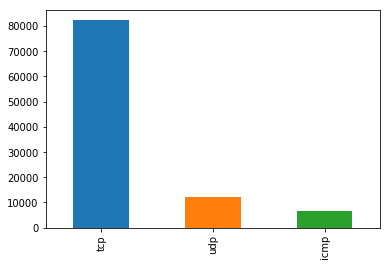

In [323]:
# Visualización del número de valores distintos que existen para la columnas categorica 'protocol_type'
%matplotlib inline

df2['protocol_type'].value_counts().plot(kind='bar')

In [324]:
# Número de valores distintos que existen para la columna categorica 'service'
df2['service'].value_counts()

http           32273
private        17474
domain_u        7254
smtp            5831
ftp_data        5492
eco_i           3632
other           3483
ecr_i           2443
telnet          1902
ftp             1405
finger          1400
auth             782
Z39_50           691
uucp             627
courier          586
bgp              565
iso_tsap         564
uucp_path        546
whois            541
time             532
imap4            514
nnsp             507
vmnet            486
urp_i            482
domain           455
ctf              446
csnet_ns         440
supdup           431
http_443         427
discard          424
               ...  
echo             343
klogin           338
ldap             335
netbios_dgm      318
sunrpc           304
netstat          292
netbios_ns       286
netbios_ssn      284
ssh              253
kshell           237
nntp             231
pop_3            201
sql_net          198
IRC              154
ntp_u            134
rje               71
remote_job   

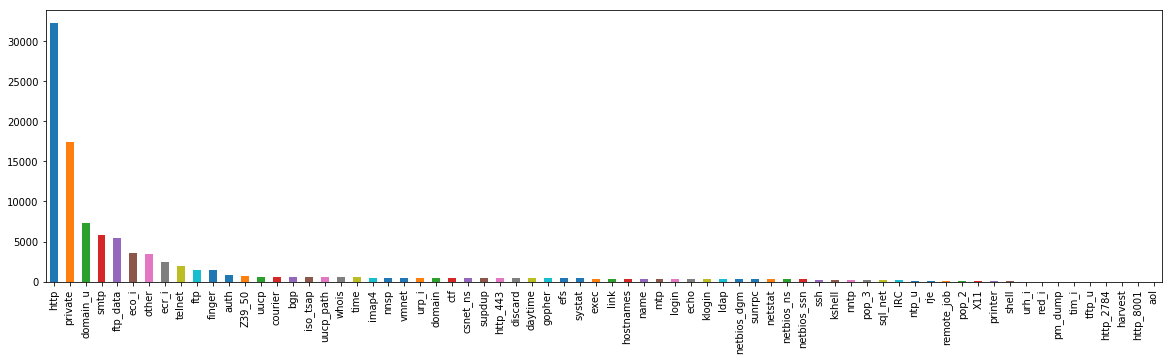

In [325]:
# Número de valores distintos que existen para la columna categorica 'service'
%matplotlib inline

df2['service'].value_counts().plot(kind='bar', figsize=(20, 5))

In [326]:
# Número de valores distintos que existen para la columna categorica 'flag'
df2['flag'].value_counts()

SF        59960
S0        27882
REJ        8978
RSTR       1941
RSTO       1270
S1          284
SH          202
S2          102
RSTOS0       83
OTH          40
S3           36
Name: flag, dtype: int64

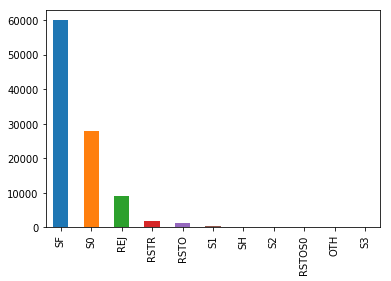

In [327]:
# Visualización del número de valores distintos que existen para la columna categorica 'flag'
%matplotlib inline

df2['flag'].value_counts().plot(kind='bar')

In [328]:
# Número de valores distintos que existen para la columna categorica 'class'
df2['Class'].value_counts()

normal             53921
neptune            32986
satan               2895
ipsweep             2866
portsweep           2358
smurf               2112
nmap                1180
back                 771
teardrop             704
warezclient          688
pod                  158
guess_passwd          42
buffer_overflow       21
land                  15
warezmaster           12
imap                  10
rootkit                9
loadmodule             9
ftp_write              8
multihop               7
phf                    3
perl                   2
spy                    1
Name: Class, dtype: int64

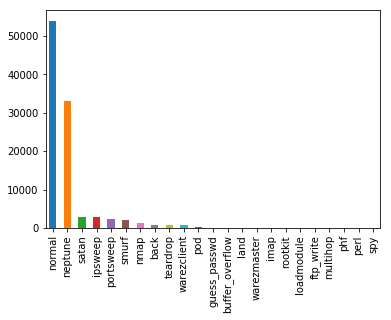

In [329]:
# Visualización del número de valores distintos que existen para la columna categorica 'flag'
%matplotlib inline

df2['Class'].value_counts().plot(kind='bar')

## 3. Correlaciones entre las características de entrada

Calcular las correlaciones entre las características de entrada y la característica de salida puede ayudarnos a diferenciar las características más importantes, así como, a añadir nuevas características.

* Se puede calcular el coeficiente de correlación estándar para ver la correlación entre cada par de atributos
* El coeficiente de correlación, solo mide **correlaciones lineales**, esto quiere decir que si x va hacia arriba, mediría si y va hacia arriba o hacia abajo.
* Hay que intentar buscar correlaciones sobre todo con el atributo objetivo o variable de salida (el que queremeos predecir)

In [330]:
# Para esta parte, voy a copiar df2 en df2_corr para realizar los tests a partir de este nuevo DataFrame
df2_corr = df2.copy()
# Uso df2_corr para la codificacion de los valores en Attack = 1; Normal (no ataque) = 0; representados en la nueva columna "Class_coded"
df2_corr["Class_coded"] = (df2_corr["Class"] != 'normal').astype(int)

In [331]:
df2_corr.head(15)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class,Class_coded
95141,0,tcp,http,SF,214,14939,0,0,0,0,...,1.00,0.00,0.02,0.06,0.00,0.0,0.00,0.0,normal,0
37486,0,tcp,private,S0,0,0,0,0,0,0,...,0.01,0.06,0.00,0.00,1.00,1.0,0.00,0.0,neptune,1
34926,0,tcp,http,REJ,0,0,0,0,0,0,...,0.03,0.06,0.00,0.00,0.00,0.0,1.00,1.0,neptune,1
34589,0,tcp,http,SF,257,259,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
11420,0,udp,other,SF,516,4,0,0,0,0,...,1.00,0.00,1.00,0.00,0.00,0.0,0.00,0.0,normal,0
46955,0,tcp,private,S0,0,0,0,0,0,0,...,0.08,0.07,0.00,0.00,1.00,1.0,0.00,0.0,neptune,1
32661,0,tcp,smtp,RSTO,0,0,0,0,0,0,...,0.00,1.00,1.00,0.00,0.00,0.0,1.00,1.0,portsweep,1
21066,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,ipsweep,1
22128,0,tcp,private,S0,0,0,0,0,0,0,...,0.07,0.08,0.00,0.00,1.00,1.0,0.00,0.0,neptune,1
21455,0,udp,private,SF,1,0,0,0,0,0,...,0.43,0.06,1.00,0.00,0.00,0.0,0.00,0.0,satan,1


In [332]:
corr_matrix = df2_corr.corr()

In [333]:
corr_matrix["Class_coded"].sort_values(ascending=False)

Class_coded                    1.000000
dst_host_srv_serror_rate       0.655604
dst_host_serror_rate           0.652823
serror_rate                    0.651517
srv_serror_rate                0.648987
count                          0.576997
dst_host_count                 0.377091
srv_rerror_rate                0.253507
dst_host_srv_rerror_rate       0.253458
rerror_rate                    0.253088
dst_host_rerror_rate           0.252110
dst_host_diff_srv_rate         0.244208
diff_srv_rate                  0.204456
wrong_fragment                 0.095437
dst_host_same_src_port_rate    0.092094
dst_host_srv_diff_host_rate    0.062914
duration                       0.049530
land                           0.008052
src_bytes                      0.006064
dst_bytes                      0.004644
srv_count                      0.000089
is_host_login                 -0.002936
urgent                        -0.003108
num_failed_logins             -0.006323
num_shells                    -0.008351


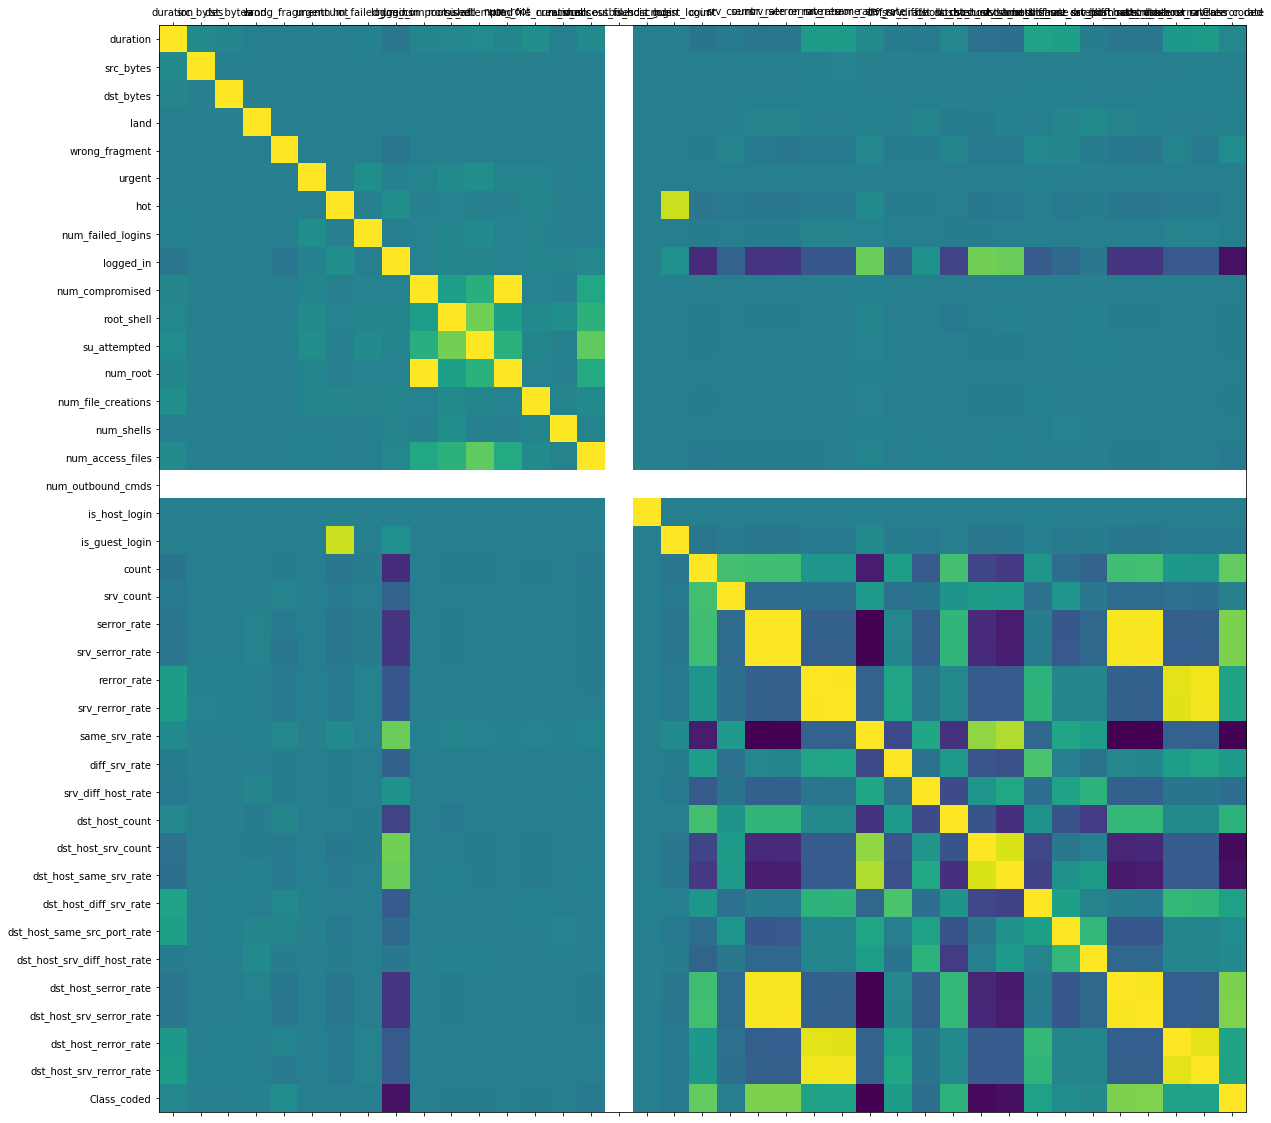

In [334]:
%matplotlib inline
import matplotlib.pyplot as plt
corr = df2_corr.corr()
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

In [335]:
# Uso el Label encoder visto en clase, para asignar valores a las columnas de tipo object que tengo
# Esto lo haré en un nuevo DataFrame(4)

In [336]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [337]:
df2_coded = encode_features(df2_corr, ["service", "protocol_type", "flag"])

In [338]:
df2_coded.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Class,Class_coded
95141,0,1,24,9,214,14939,0,0,0,0,...,1.00,0.00,0.02,0.06,0.0,0.0,0.0,0.0,normal,0
37486,0,1,49,5,0,0,0,0,0,0,...,0.01,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune,1
34926,0,1,24,1,0,0,0,0,0,0,...,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,1
34589,0,1,24,9,257,259,0,0,0,0,...,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,normal,0
11420,0,2,44,9,516,4,0,0,0,0,...,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,normal,0


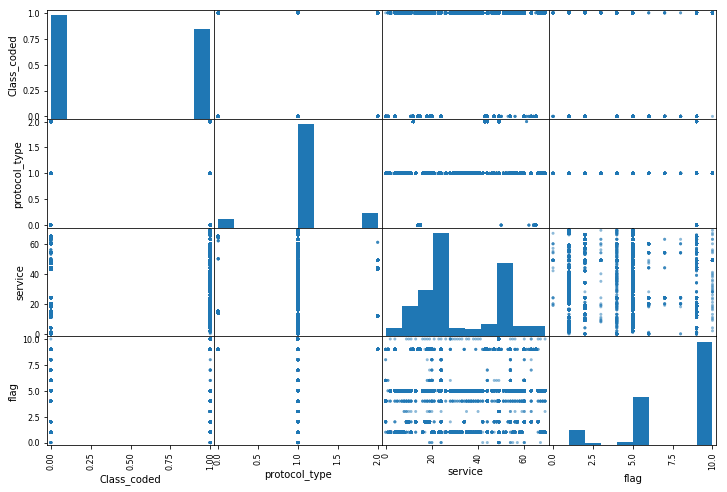

In [339]:
from pandas.plotting import scatter_matrix

attributes = ["Class_coded", "protocol_type", "service", "flag"]

scatter_matrix(df2_coded[attributes], figsize=(12,8))
plt.show()

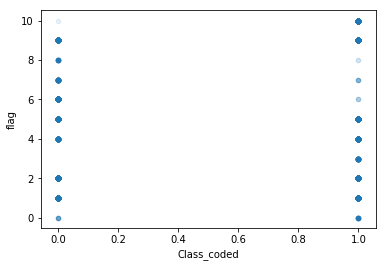

In [340]:
df2_coded.plot(kind='scatter', x='Class_coded', y='flag', alpha=0.1)
plt.show()

## 4. Preprocesamiento del conjunto de datos

###     4.1. Limpiando el conjunto de datos

La mayoria de los algoritmos de Machine Learning no pueden trabajar sobre caracteristicas que contengan valores nulos. Comprueba si el conjunto de datos contine valores nulos, de ser así, aplica alguna de las técnicas que se han visto a lo largo del curso para reemplazarlos:
* Eliminar las filas correspondientes
* Eliminar el atributo (columna) correspondiente
* Rellenarlos con un valor determinado (cero, media ...)

In [341]:
df2.isna().any()

duration                       False
protocol_type                  False
service                        False
flag                           False
src_bytes                      False
dst_bytes                      False
land                           False
wrong_fragment                 False
urgent                         False
hot                            False
num_failed_logins              False
logged_in                      False
num_compromised                False
root_shell                     False
su_attempted                   False
num_root                       False
num_file_creations             False
num_shells                     False
num_access_files               False
num_outbound_cmds              False
is_host_login                  False
is_guest_login                 False
count                          False
srv_count                      False
serror_rate                    False
srv_serror_rate                False
rerror_rate                    False
s

* No hay datos nulos en nuestro Dataframe

### 4.2. Transformación de los atributos categóricos

Los algoritmos de Machine Learning, por norma general, ingieren datos numéricos. Comprueba si existen valores categóricos en el conjunto de datos y aplica las transoformaciones necesarias para convertirlos a valores numéricos.  
**Justifica tu decisión**.

In [342]:
# He usado get_dummies porque tuve problemas para implementar One Hot Encoder, aunque el resultado es el mismo
# Las columnas que he dividido a valores numericos eran aquellas formadas por valores categoricos, es decir, aquellas cuyo
# tipo era 'object': protocol_type, service, flag y Class
df2_coded = pd.get_dummies(df2, columns=['protocol_type', 'service', 'flag', 'Class'])
df2_coded.dtypes

duration                   int64
src_bytes                  int64
dst_bytes                  int64
land                       int64
wrong_fragment             int64
urgent                     int64
hot                        int64
num_failed_logins          int64
logged_in                  int64
num_compromised            int64
root_shell                 int64
su_attempted               int64
num_root                   int64
num_file_creations         int64
num_shells                 int64
num_access_files           int64
num_outbound_cmds          int64
is_host_login              int64
is_guest_login             int64
count                      int64
srv_count                  int64
serror_rate              float64
srv_serror_rate          float64
rerror_rate              float64
srv_rerror_rate          float64
same_srv_rate            float64
diff_srv_rate            float64
srv_diff_host_rate       float64
dst_host_count             int64
dst_host_srv_count         int64
          

* Ahora todas las columnas son de tipo numéricos

### 4.3. Escalado del conjunto de datos

Si los valores del conjunto de datos se encuentran en rangos muy diferentes, es posible que deban aplicarse técnicas de normalización o escalado para que el algoritmo de Machine Learning funcione mejor.  

Comprueba si los datos del conjunto de datos poseen valores muy dispares y, si se considera necesario, aplica una de las técnicas de escalado o normalización vista durante el curso. **Justifica tu decisión.**

In [343]:
from sklearn.preprocessing import RobustScaler

# Para el conjunto de entrenamiento
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(df2_coded)

In [344]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled)
X_train_scaled.head(15)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,0.0,0.615942,28.673704,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.771739,0.497121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.710145,0.007678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,-0.155797,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


* El escalado ha producido un rodendeo de los valores, que ahora pasan a valor 0 o 1 (exactos). esto supone una gran pérdida de información, y por ello **no realizaré el escalado** de datos para este ejercicio concreto.

## 5. Selección y entrenamiento de los modelos

¡En este punto ya hemos realizado todas las transformaciones necesarias sobre los datos para que puedan ser ingeridos por un algoritmo de machine Learning!

Recuerda que debes seleccionar al menos dos algoritmos para completar el ejercicio:
* Un algoritmo de clasificación basado en aprendizaje supervisado (regresión logística, árbol de decisión, random forest)
* Un algoritmo de detección de anomalías (distribución gaussiana, isolation forest)

## 5.1. Algoritmo de clasificación elegido: Decision Tree Classifier

### 5.1.1. Carga de datos

In [345]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [346]:
# Divido los Datasets en entrada (X_train, X_test) y salida (Y_train, Y_test) mediante la separación de la columna "Class", 
# que considero el output buscado, puesto que indica si ha habido ataque o no

Y_train = pd.DataFrame({'Class' : []})
Y_train['Class'] = X_train['Class']
X_train = X_train.drop('Class', axis=1)

Y_test = pd.DataFrame({'Class' : []})
Y_test['Class'] = X_test['Class']
X_test = X_test.drop('Class', axis=1)

In [347]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50)

In [348]:
# Convierto Y_train e Y_test de Series a DataFrames
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

In [349]:
# Llegados a este punto, voy a codificar los valores de la columna "Class" para los dataset de salida (Y's):
#    1 si es distinto de 'normal' y 0 si es igual
# (Lo podría haber hecho con el Label Encoder de antes, pero lo quise hacer de nuevo. El resultado es similar)

# NOTA: Cabe señalar que no podemos usar GET_DUMMIES o ONE_HOT-ENCODER, ya que el numero de columnas del dataset de 
# entrenamiento y el de test (o validación) puede ser diferente, y dará lugar a un error en la fase de predicción


Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

In [350]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [351]:
Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

In [352]:
# Codifico los conjuntos de entrada (X's) con el Label Encoder visto antes
X_train = encode_features(X_train, ["service", "protocol_type", "flag"])
X_test = encode_features(X_test, ["service", "protocol_type", "flag"])
X_val = encode_features(X_val, ["service", "protocol_type", "flag"])

In [353]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])

X_train: Filas: 125973 , columnas: 41
Y_train: Filas: 125973 , columnas: 1
X_test: Filas: 11272 , columnas: 41
Y_test: Filas: 11272 , columnas: 1
X_val: Filas: 11272 , columnas: 41
Y_val: Filas: 11272 , columnas: 1


In [354]:
# Entrenamiento del modelo
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [355]:
# Predicción de valores
Y_train_pred = clf.predict(X_train)
Y_test_pred = clf.predict(X_test)
Y_val_pred = clf.predict(X_val)

In [356]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nEntrenamiento Decision Tree Classifier")
print(confusion_matrix(Y_train, Y_train_pred))
print("\nTest Decision Tree Classifier")
print(confusion_matrix(Y_test, Y_test_pred))
print("\nValidación Decision Tree Classifier")
print(confusion_matrix(Y_val, Y_val_pred))


Entrenamiento Decision Tree Classifier
[[67343     0]
 [    7 58623]]

Test Decision Tree Classifier
[[4711  135]
 [2397 4029]]

Validación Decision Tree Classifier
[[4712  153]
 [2389 4018]]


In [357]:
f1_score_dectree_train = f1_score(Y_train_pred, Y_train, average="binary")
f1_score_dectree_test = f1_score(Y_test_pred, Y_test, average="binary")
f1_score_dectree_val = f1_score(Y_val_pred, Y_val, average="binary")

print("F1 Score for train set:", f1_score_dectree_train)
print("F1 Score for test set:", f1_score_dectree_test)
print("F1 Score for validation set:", f1_score_dectree_val)

F1 Score for train set: 0.9999403000349671
F1 Score for test set: 0.7609065155807365
F1 Score for validation set: 0.7596899224806203


## 5.2. Algoritmo de detección de anomalías elegido: distribución gaussiana

## 5.2.1. Carga de los datos

In [358]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

# Test data
X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [359]:
# División del conjunto de entrenamiento en "Ataque" y "Normal" (= no ataque)
X_train_normal = X_train[X_train['Class'] == 'normal']
X_train_attack = X_train[X_train['Class'] != 'normal']

# División del conjunto de test en "Ataque" y "Normal" (= no ataque)
X_test_normal = X_test[X_test['Class'] == 'normal']
X_test_attack = X_test[X_test['Class'] != 'normal']

In [360]:
# División del conjunto de entrenamiento "normal" (= no ataques) en Entrada (X) y salida (Y)
Y_train_normal = X_train_normal['Class']
X_train_normal = X_train_normal.drop('Class', axis=1)

# División del conjunto de entrenamiento "ataque" en Entrada (X) y salida (Y)
Y_train_attack = X_train_attack['Class']
X_train_attack = X_train_attack.drop('Class', axis=1)

# División del conjunto de test "normal" (= no ataques) en Entrada (X) y salida (Y)
Y_test_normal = X_test_normal['Class']
X_test_normal = X_test_normal.drop('Class', axis=1)

# División del conjunto de test "ataque" en Entrada (X) y salida (Y)
Y_test_attack = X_test_attack['Class']
X_test_attack = X_test_attack.drop('Class', axis=1)

In [361]:
# Creación de los conjuntos de validación a partir de la división de los de test (50%-50%)
from sklearn.model_selection import train_test_split

X_test_normal, X_val_normal, Y_test_normal, Y_val_normal = train_test_split(X_test_normal, Y_test_normal, test_size=0.50)
X_test_attack, X_val_attack, Y_test_attack, Y_val_attack = train_test_split(X_test_attack, Y_test_attack, test_size=0.50)

### Mezclamos ejemplos legítimos y maliciosos en validación y pruebas

In [362]:
import pandas as pd

# Conjunto de datos de entrenamiento
X_train = pd.concat([X_train_normal, X_train_attack], ignore_index=True)
Y_train = pd.concat([Y_train_normal, Y_train_attack], ignore_index=True)

# Conjunto de datos de pruebas
X_test = pd.concat([X_test_normal, X_test_attack], ignore_index=True)
Y_test = pd.concat([Y_test_normal, Y_test_attack], ignore_index=True)

# Conjunto de datos de validacion
X_val = pd.concat([X_val_normal, X_val_attack], ignore_index=True)
Y_val = pd.concat([Y_val_normal, Y_val_attack], ignore_index=True)

In [363]:
# Método de codificación: Label Encoder

# Al igual que antes, no podemos usar GET_DUMMIES ni ONE_HOT-ENCODER porque el numero de columnas es diferente para el dataset
# de train y test (y validación)

from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [364]:
# Codificación de todos los conjuntos de datos para los casos en lo que las columnas son de tipo Object
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

X_train = encode_features(X_train, ["service", "protocol_type", "flag"])
X_test = encode_features(X_test, ["service", "protocol_type", "flag"])
X_val = encode_features(X_val, ["service", "protocol_type", "flag"])

X_train_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])
X_val_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])
X_test_normal = encode_features(X_train_normal, ["service", "protocol_type", "flag"])

X_train_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])
X_val_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])
X_test_attack = encode_features(X_train_attack, ["service", "protocol_type", "flag"])

In [365]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])
print ("X_train_normal: Filas:", X_train_normal.shape[0], ", columnas:", X_train_normal.shape[1])
print ("X_test_normal: Filas:", X_test_normal.shape[0], ", columnas:", X_test_normal.shape[1])
print ("X_val_normal: Filas:", X_val_normal.shape[0], ", columnas:", X_val_normal.shape[1])
print ("X_train_attack: Filas:", X_train_attack.shape[0], ", columnas:", X_train_attack.shape[1])
print ("X_test_attack: Filas:", X_test_attack.shape[0], ", columnas:", X_test_attack.shape[1])
print ("X_val_attack: Filas:", X_val_attack.shape[0], ", columnas:", X_val_attack.shape[1])

X_train: Filas: 125973 , columnas: 41
Y_train: Filas: 125973 , columnas: 1
X_test: Filas: 11271 , columnas: 41
Y_test: Filas: 11271 , columnas: 1
X_val: Filas: 11273 , columnas: 41
Y_val: Filas: 11273 , columnas: 1
X_train_normal: Filas: 67343 , columnas: 41
X_test_normal: Filas: 67343 , columnas: 41
X_val_normal: Filas: 67343 , columnas: 41
X_train_attack: Filas: 58630 , columnas: 41
X_test_attack: Filas: 58630 , columnas: 41
X_val_attack: Filas: 58630 , columnas: 41


## Visualizando el conjunto de datos

In [366]:
X_train_normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67343 entries, 0 to 125972
Data columns (total 41 columns):
duration                       67343 non-null int64
protocol_type                  67343 non-null int64
service                        67343 non-null int64
flag                           67343 non-null int64
src_bytes                      67343 non-null int64
dst_bytes                      67343 non-null int64
land                           67343 non-null int64
wrong_fragment                 67343 non-null int64
urgent                         67343 non-null int64
hot                            67343 non-null int64
num_failed_logins              67343 non-null int64
logged_in                      67343 non-null int64
num_compromised                67343 non-null int64
root_shell                     67343 non-null int64
su_attempted                   67343 non-null int64
num_root                       67343 non-null int64
num_file_creations             67343 non-null int64
num_sh

In [367]:
X_train_normal.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,9,8,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,13,8,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
3,0,1,10,8,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,10,8,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12,0,1,10,8,287,2251,0,0,0,0,...,8,219,1.00,0.00,0.12,0.03,0.00,0.00,0.00,0.00
16,0,1,10,8,300,13788,0,0,0,0,...,91,255,1.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00
18,0,1,10,8,233,616,0,0,0,0,...,66,255,1.00,0.00,0.02,0.03,0.00,0.00,0.02,0.00
19,0,1,10,8,343,1178,0,0,0,0,...,157,255,1.00,0.00,0.01,0.04,0.00,0.00,0.00,0.00
22,0,1,10,8,253,11905,0,0,0,0,...,87,255,1.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00
23,5607,2,13,8,147,105,0,0,0,0,...,255,1,0.00,0.85,1.00,0.00,0.00,0.00,0.00,0.00


C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value enco

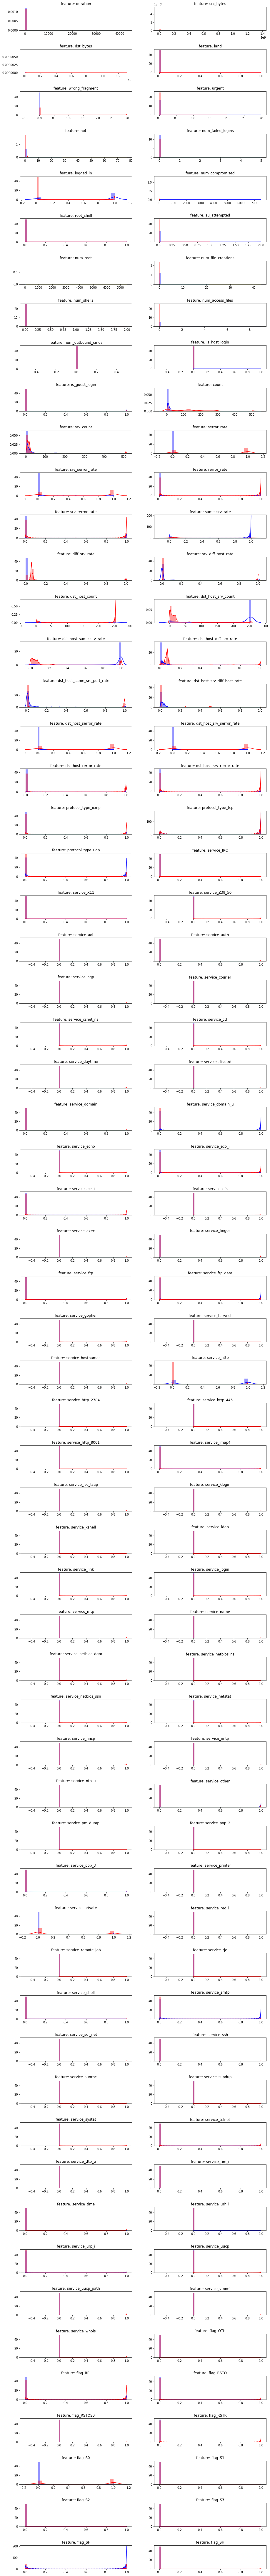

In [368]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

df = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
df = df.drop('temp', axis=1)

df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'])

features = [f for f in list(df)
            if f not in ["Class", "protocol_type", "service", "flag"]]

plt.figure(figsize=(15,20*8))
gs = gridspec.GridSpec(61, 2)    #len(features) = 122
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 'normal'], color = "b")
    sns.distplot(df[f][df["Class"] != 'normal'], color = "r")
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

## 5.2.2. Implementando el algoritmo de distribución Gaussiana

In [369]:
from scipy.stats import multivariate_normal
import numpy as np

class GaussianDistribution:
    def __init__(self):
        self._mu = None
        self._sigma = None
        
    def fit(self, X_train):
        self._mu, self._sigma = self._estimateGaussian(X_train)
        
    def predict(self, X_pred, threshold):
        pred = self.multivariateGaussian(X_pred)
        return (pred < threshold)

    def multivariateGaussian(self, dataset):
        pred = multivariate_normal(mean=self._mu, cov=self._sigma, allow_singular=True)
        return pred.pdf(dataset)
        
    def _estimateGaussian(self, dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.cov(dataset.T)
        return mu, sigma

In [370]:
from sklearn.metrics import f1_score

def search_threshold(Y_val, preds_val):
    best_f1 = 0
    best_threshold = 0
    threshold = 1
    for i in range(900):
        threshold = threshold / 2
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / 900 * 100)), end='')
        predictions = (preds_val < threshold)
        f1 = f1_score(Y_val, predictions, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return (best_f1, best_threshold)

## 5.2.3. Creación del modelo

In [371]:
# Instanciamos el algoritmo de distribución gaussiana, y los entrenamos UNICAMENTE con los valores que no son ataques (='normal')
gauss = GaussianDistribution()

gauss.fit(X_train_normal)

**Realizo la predicción con el subconjunto de validación**

In [372]:
val_preds = gauss.multivariateGaussian(X_val)

**Busco el mejor Threshold**

In [373]:
best_f1, threshold = search_threshold(Y_val, val_preds)
print("\n\nBest threshold:", threshold, "- F1 Score:", best_f1)

Searching best threshold 100%

Best threshold: 1.2924697071141057e-26 - F1 Score: 0.7848392036753445


**Verifico en Threshold con el conjunto de pruebas**

In [374]:
test_preds = gauss.predict(X_test, threshold)

In [375]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nTest Distribución Gaussiana")
print(confusion_matrix(Y_test, test_preds))


Test Distribución Gaussiana
[[3332 1523]
 [1342 5074]]


In [376]:
f1_score_gauss_test = f1_score(Y_test, test_preds, average = "binary")

print("F1 Score for test set:", f1_score_gauss_test)

F1 Score for test set: 0.7798355490663184


## 5.2.4. Selección de características

#### Llegados a este punto, vamos a colver a evaluar el modelo, pero teniendo en cuenta únicamente las features (parámetros de nuestro dataset) en los que realmente se nota una diferencia entre los registros referidos a los ataques y a los normales (no-ataques)

#### Haremos la evaluación de la importancia de parámetros usando el algoritmo Random forest

In [377]:
import pandas as pd

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate", "Class", "temp"]

# Training data
X_train_fs = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train_fs = X_train_fs.drop('temp', axis=1)

Y_train_fs = pd.DataFrame({'Class' : []})
Y_train_fs['Class'] = X_train_fs['Class']
X_train_fs = X_train_fs.drop('Class', axis=1)

# Test data
X_test_fs = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test_fs = X_test_fs.drop('temp', axis=1)

Y_test_fs = pd.DataFrame({'Class' : []})
Y_test_fs['Class'] = X_test_fs['Class']
X_test_fs = X_test_fs.drop('Class', axis=1)

In [378]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [379]:
# Codificación de todos los conjuntos de datos para los cosas en lo qe las columnas son de tipo Object
X_train_fs = encode_features(X_train_fs, ["service", "protocol_type", "flag"])
X_test_fs = encode_features(X_test_fs, ["service", "protocol_type", "flag"])

Y_train_fs = pd.DataFrame(Y_train_fs)
Y_test_fs = pd.DataFrame(Y_test_fs)

Y_train_fs["Class_coded"] = (Y_train_fs["Class"].astype(str) != 'normal').astype(int)
Y_test_fs["Class_coded"] = (Y_test_fs["Class"].astype(str) != 'normal').astype(int)

Y_train_fs = Y_train_fs.drop('Class', axis=1)
Y_test_fs = Y_test_fs.drop('Class', axis=1)

#### Entrenamos el algoritmo Random Forest

In [380]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rnd_clf.fit(X_train_fs, Y_train_fs)

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [381]:
# Conjunto de los valores de entrada
X_fs = pd.concat([X_train_fs, X_test_fs], ignore_index=True)

In [382]:
for name, score in zip(list(X_fs), rnd_clf.feature_importances_):
    print(name, score)

duration 0.004031345674560061
protocol_type 0.03734132905350795
service 0.03022001148581646
flag 0.05453974550373958
src_bytes 0.20984239349395495
dst_bytes 0.16363677853770223
land 3.628458430767393e-05
wrong_fragment 0.003882916222929023
urgent 2.4556119442565444e-05
hot 0.008603573626850889
num_failed_logins 0.00018479459625511078
logged_in 0.030441487677413406
num_compromised 0.006129729816072195
root_shell 9.931154526925812e-05
su_attempted 1.4211365601141307e-05
num_root 0.0002713482173094544
num_file_creations 0.0001632239436840869
num_shells 6.088773986951272e-05
num_access_files 5.8737881222211904e-05
num_outbound_cmds 0.0
is_host_login 0.0
is_guest_login 0.0009320803406929305
count 0.027740659945789368
srv_count 0.017197077857431926
serror_rate 0.004552010521938557
srv_serror_rate 0.0033840254571922616
rerror_rate 0.006115147330071952
srv_rerror_rate 0.00261213031991311
same_srv_rate 0.07368970796769389
diff_srv_rate 0.0845564789277572
srv_diff_host_rate 0.005361693257755857


In [383]:
for name, score in zip(list(X_fs), rnd_clf.feature_importances_):
    if score > 0.02:
        print("\"" + name + "\"", end=",")

"protocol_type","service","flag","src_bytes","dst_bytes","logged_in","count","same_srv_rate","diff_srv_rate","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_serror_rate",

## 5.2.5. Reevaluación del modelo

#### Vamos a volver a evaluar nuestro modelo de Machine Learning de Distribución Gaussiana, pero ahora con las características más inlfuyentes, vistas en el apartado anterior

## 5.2.1. Carga de los datos

In [384]:
import pandas as pd

columns = ["protocol_type","service","flag","src_bytes","dst_bytes","logged_in","count","srv_serror_rate","same_srv_rate","diff_srv_rate","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate", "Class", "temp"]

# Training data
X_train = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
X_train = X_train.drop('temp', axis=1)

# Test data
X_test = pd.read_csv("NSL-KDD/KDDTest+.txt", names=columns)
X_test = X_test.drop('temp', axis=1)

In [385]:
X_train_normal = X_train[X_train['Class'] == 'normal']
X_train_attack = X_train[X_train['Class'] != 'normal']

X_test_normal = X_test[X_test['Class'] == 'normal']
X_test_attack = X_test[X_test['Class'] != 'normal']

In [386]:
# Ejemplos normales - train
Y_train_normal = X_train_normal['Class']
X_train_normal = X_train_normal.drop('Class', axis=1)

# Ejemplos ataques - train
Y_train_attack = X_train_attack['Class']
X_train_attack = X_train_attack.drop('Class', axis=1)

# Ejemplos normales - test
Y_test_normal = X_test_normal['Class']
X_test_normal = X_test_normal.drop('Class', axis=1)

# Ejemplos ataques - test
Y_test_attack = X_test_attack['Class']
X_test_attack = X_test_attack.drop('Class', axis=1)

In [387]:
# División del conjunto de test en test y validacion
from sklearn.model_selection import train_test_split

X_test_normal, X_val_normal, Y_test_normal, Y_val_normal = train_test_split(X_test_normal, Y_test_normal, test_size=0.50)
X_test_attack, X_val_attack, Y_test_attack, Y_val_attack = train_test_split(X_test_attack, Y_test_attack, test_size=0.50)

### Mezclamos ejemplos legítimos y maliciosos en validación y pruebas

In [388]:
import pandas as pd

# Conjunto de datos de pruebas
X_train = pd.concat([X_train_normal, X_train_attack], ignore_index=True)
Y_train = pd.concat([Y_train_normal, Y_train_attack], ignore_index=True)

# Conjunto de datos de pruebas
X_test = pd.concat([X_test_normal, X_test_attack], ignore_index=True)
Y_test = pd.concat([Y_test_normal, Y_test_attack], ignore_index=True)

# Conjunto de datos de validacion
X_val = pd.concat([X_val_normal, X_val_attack], ignore_index=True)
Y_val = pd.concat([Y_val_normal, Y_val_attack], ignore_index=True)

In [389]:
# Como antes, codificamos con LabelEncoder

from sklearn.preprocessing import LabelEncoder

def encode_features(df, list_features):
    label_encoder = LabelEncoder()
    for f in list_features:
        df[f] = label_encoder.fit_transform(df[f])
    return df

In [390]:
# Codificación de todos los conjuntos de datos para los cosas en lo qe las columnas son de tipo Object
X_train = encode_features(X_train, ["protocol_type", "flag"])
X_test = encode_features(X_test, ["protocol_type", "flag"])
X_val = encode_features(X_val, ["protocol_type", "flag"])

Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

Y_train["Class_coded"] = (Y_train["Class"].astype(str) != 'normal').astype(int)
Y_test["Class_coded"] = (Y_test["Class"].astype(str) != 'normal').astype(int)
Y_val["Class_coded"] = (Y_val["Class"].astype(str) != 'normal').astype(int)

Y_train = Y_train.drop('Class', axis=1)
Y_test = Y_test.drop('Class', axis=1)
Y_val = Y_val.drop('Class', axis=1)

X_train_normal = encode_features(X_train_normal, ["protocol_type", "flag"])
X_val_normal = encode_features(X_train_normal, ["protocol_type", "flag"])
X_test_normal = encode_features(X_train_normal, ["protocol_type", "flag"])

X_train_attack = encode_features(X_train_attack, ["protocol_type", "flag"])
X_val_attack = encode_features(X_train_attack, ["protocol_type", "flag"])
X_test_attack = encode_features(X_train_attack, ["protocol_type", "flag"])

In [391]:
print ("X_train: Filas:", X_train.shape[0], ", columnas:", X_train.shape[1])
print ("Y_train: Filas:", Y_train.shape[0], ", columnas:", Y_train.shape[1])
print ("X_test: Filas:", X_test.shape[0], ", columnas:", X_test.shape[1])
print ("Y_test: Filas:", Y_test.shape[0], ", columnas:", Y_test.shape[1])
print ("X_val: Filas:", X_val.shape[0], ", columnas:", X_val.shape[1])
print ("Y_val: Filas:", Y_val.shape[0], ", columnas:", Y_val.shape[1])
print ("X_train_normal: Filas:", X_train_normal.shape[0], ", columnas:", X_train_normal.shape[1])
print ("X_test_normal: Filas:", X_test_normal.shape[0], ", columnas:", X_test_normal.shape[1])
print ("X_val_normal: Filas:", X_val_normal.shape[0], ", columnas:", X_val_normal.shape[1])
print ("X_train_attack: Filas:", X_train_attack.shape[0], ", columnas:", X_train_attack.shape[1])
print ("X_test_attack: Filas:", X_test_attack.shape[0], ", columnas:", X_test_attack.shape[1])
print ("X_val_attack: Filas:", X_val_attack.shape[0], ", columnas:", X_val_attack.shape[1])

X_train: Filas: 125973 , columnas: 14
Y_train: Filas: 125973 , columnas: 1
X_test: Filas: 11271 , columnas: 14
Y_test: Filas: 11271 , columnas: 1
X_val: Filas: 11273 , columnas: 14
Y_val: Filas: 11273 , columnas: 1
X_train_normal: Filas: 67343 , columnas: 14
X_test_normal: Filas: 67343 , columnas: 14
X_val_normal: Filas: 67343 , columnas: 14
X_train_attack: Filas: 58630 , columnas: 14
X_test_attack: Filas: 58630 , columnas: 14
X_val_attack: Filas: 58630 , columnas: 14


## Visualizando el conjunto de datos

In [392]:
X_train_normal.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 67343 entries, (0, tcp, ftp_data, SF, 491, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0.0, 0.0, 0.0) to (0, tcp, ftp_data, SF, 151, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.0, 0.0, 0.0)
Data columns (total 14 columns):
protocol_type                  67343 non-null int64
service                        67343 non-null float64
flag                           67343 non-null int64
src_bytes                      67343 non-null float64
dst_bytes                      67343 non-null int64
logged_in                      67343 non-null int64
count                          67343 non-null float64
srv_serror_rate                67343 non-null float64
same_srv_rate                  67343 non-null float64
diff_srv_rate                  67343 non-null float64
dst_host_srv_count             67343 non-null float64
dst_host_same_srv_rate         67343 non-null float64
dst_host_diff_srv_rate         67343 non-null float64
dst_h

In [393]:
X_train_normal.head(10)

protocol_type  \
0    tcp ftp_data SF 491 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2  2  0.0 0.00 0.0              0   
     udp other    SF 146 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 1  0.0 0.00 0.0              0   
     tcp http     SF 232 8153  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 5  5  0.2 0.20 0.0              0   
                     199 420   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 30 32 0.0 0.00 0.0              0   
                     287 2251  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  7  0.0 0.00 0.0              0   
                     300 13788 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  9  0.0 0.11 0.0              0   
                     233 616   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  3  0.0 0.00 0.0              0   
                     343 1178  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 9  10 0.0 0.00 0.0              0   
                     253 11905 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  10 0.0 0.00 0.0              0   
5607 udp other    SF 147 105   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1  1  0.0 0.00 0.0              0   

                                                                                   service  \
0    tcp ftp_data SF 491 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2  2  0.0 0.00 0.0     1.00   
     udp other    SF 146 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 1  0.0 0.00 0.0     0.08   
     tcp http     SF 232 8153  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 5  5  0.2 0.20 0.0     1.00   
                     199 420   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 30 32 0.0 0.00 0.0     1.00   
                     287 2251  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  7  0.0 0.00 0.0     1.00   
                     300 13788 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  9  0.0 0.11 0.0     1.00   
                     233 616   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  3  0.0 0.00 0.0     1.00   
                     343 1178  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 9  10 0.0 0.00 0.0     1.00   
                     253 11905 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  10 0.0 0.00 0.0     1.00   
5607 udp other    SF 147 105   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1  1  0.0 0.00 0.0     1.00   

                                                                                   flag  \
0    tcp ftp_data SF 491 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2  2  0.0 0.00 0.0     0   
     udp other    SF 146 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 1  0.0 0.00 0.0    15   
     tcp http     SF 232 8153  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 5  5  0.2 0.20 0.0     0   
                     199 420   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 30 32 0.0 0.00 0.0     0   
                     287 2251  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  7  0.0 0.00 0.0     0   
                     300 13788 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  9  0.0 0.11 0.0     0   
                     233 616   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  3  0.0 0.00 0.0     0   
                     343 1178  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 9  10 0.0 0.00 0.0     0   
                     253 11905 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  10 0.0 0.00 0.0     0   
5607 udp other    SF 147 105   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1  1  0.0 0.00 0.0     0   

                                                                                   src_bytes  \
0    tcp ftp_data SF 491 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2  2  0.0 0.00 0.0       0.00   
     udp other    SF 146 0     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 13 1  0.0 0.00 0.0       0.00   
     tcp http     SF 232 8153  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 5  5  0.2 0.20 0.0       0.00   
                     199 420   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 30 32 0.0 0.00 0.0       0.09   
                     287 2251  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  7  0.0 0.00 0.0       0.43   
                     300 13788 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  9  0.0 0.11 0.0       0.22   
                     233 616   0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3  3  0.0 0.00 0.0       0.00   
                     343 1178  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 9  10 0.0 0.00 0.0       0.20   
                     253 11905 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8  10 0.0 0.00 0.0

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


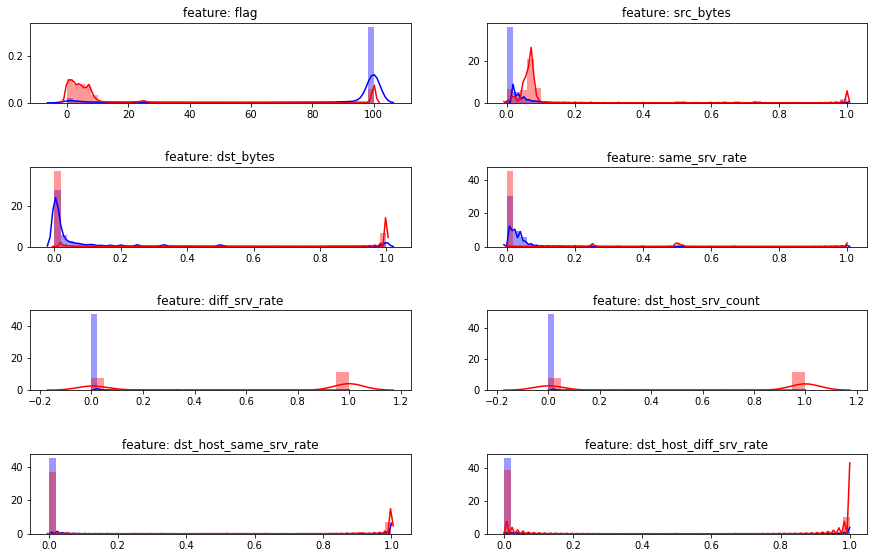

In [394]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

columns = ["flag","src_bytes","dst_bytes","same_srv_rate","diff_srv_rate","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate", "Class", "temp"]
    
df = pd.read_csv("NSL-KDD/KDDTrain+.txt", names=columns)
df = df.drop('temp', axis=1)

df = encode_features(df, ["flag"])

features = [f for f in list(df)
            if f not in ["Class"]]

plt.figure(figsize=(15,20*8))
gs = gridspec.GridSpec(61, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["Class"] == 'normal'], color = "b")
    sns.distplot(df[f][df["Class"] != 'normal'], color = "r")
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

## 5.2.2. Implementando el algoritmo de distribución Gaussiana

In [395]:
from scipy.stats import multivariate_normal
import numpy as np

class GaussianDistribution:
    def __init__(self):
        self._mu = None
        self._sigma = None
        
    def fit(self, X_train):
        self._mu, self._sigma = self._estimateGaussian(X_train)
        
    def predict(self, X_pred, threshold):
        pred = self.multivariateGaussian(X_pred)
        return (pred < threshold)

    def multivariateGaussian(self, dataset):
        pred = multivariate_normal(mean=self._mu, cov=self._sigma, allow_singular=True)
        return pred.pdf(dataset)
        
    def _estimateGaussian(self, dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.cov(dataset.T)
        return mu, sigma

In [396]:
from sklearn.metrics import f1_score

def search_threshold(Y_val, preds_val):
    best_f1 = 0
    best_threshold = 0
    threshold = 1
    for i in range(900):
        threshold = threshold / 2
        print("\rSearching best threshold {0}%".format(
            int((i + 1) / 900 * 100)), end='')
        predictions = (preds_val < threshold)
        f1 = f1_score(Y_val, predictions, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return (best_f1, best_threshold)

## 5.2.3. Creación del modelo

In [397]:
# Instanciacimos el algoritmo de distribución gaussiana
gauss = GaussianDistribution()

gauss.fit(X_train_normal)

**Predicción para el conjunto de validación**

In [398]:
val_preds = gauss.multivariateGaussian(X_val)

**Busco el mejor Threshold**

In [399]:
best_f1, threshold = search_threshold(Y_val, val_preds)
print("\n\nBest threshold:", threshold, "- F1 Score:", best_f1)

Searching best threshold 57%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 66%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 74%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 80%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 85%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 90%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 95%

C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

Searching best threshold 100%

Best threshold: 2.384185791015625e-07 - F1 Score: 0.8578143360752057


C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ijaramat\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

**Verifico en Threshold con el conjunto de pruebas**

In [400]:
test_preds = gauss.predict(X_test, threshold)

In [401]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score

print("\nTest Distribución Gaussiana")
print(confusion_matrix(Y_test, test_preds))


Test Distribución Gaussiana
[[4440  415]
 [1355 5061]]


In [402]:
f1_score_gauss_test = f1_score(Y_test, test_preds, average = "binary")

print("F1 Score for test set:", f1_score_gauss_test)

F1 Score for test set: 0.8511604439959637


## 6. Métricas y comparación de los resultados

Selecciona un conjunto de métricas que permitan evaluar de manera adecuada el resultado de los modelos que has entrenado previamente. **Justifica tu decisión**  

Compara los resultados obtenidos con ambos modelos y **justifica la razón por la que consideras que un modelo se comporta mejor que el otro.**

Fijándonos en el F1-Score (aunque también podríamos hacerlo con las Matrices de Confusión que hemos obtenido), los resultados  han sido:

1) **Decision Tree Classifier**
   - F1_score for test set: _0.7609065155807365_

2) **Distribución Gaussiana**
   - F1 Score for test set: _0.7798355490663184_
   

3) **Distribución Gaussiana +** Elección de características mediante **Random Forest**
   - F1 Score for test set: _0.8511604439959637_

* Aunque los valores cambian ligeramente cada vez que entrenamos los algoritmos, no suponen una gran diferencia, y por tanto podemos concluir que los mejores resultados se obtienen en el tercer caso (**Distr. Gaussiana + Random Forest**), en el que la aplicación de Random Forest para la elección de los paramétros del dataset puede mejorar en torno al _7,5-9%_ la clasificación correcta de las muestras respecto a Decision Tree Classifier y a la Gaussiana sin elección de características.